In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import rasterio as rio
from rasterio import CRS
from rasterio.transform import from_origin
from rasterio.plot import show
from rasterio.plot import show_hist
import tensorflow as tf
import keras
from keras import models, layers, utils, backend as K
import shap

from functions import one_hot_encode, preprocess, binary_classification_preprocess, multiclass_classification_preprocess, nn_regression_preprocess
from functions import linear_regression, logistic_regression, decision_tree, random_forest, neural_net
from neural_net_functions import DNN_functional, get_compiled_model, dense_block, run_training, neural_net, nn_regression_preprocess

In [2]:
# reads a portion of raster
def read_image_chunk(band, path, xgeo, ygeo, width, height):
    with rio.open(path) as ds:
        row, col = ds.index(xgeo, ygeo)
        data = ds.read(band,
            window=rio.windows.Window(col, row, width, height)
            )
    return data

In [3]:
# reads all files and adds each band/window of 200x200 to images array
paths = ['data/geoKARMA_h24v13_aspect_2019.tif',
         'data/geoKARMA_h24v13_dem_2019.tif',
         'data/geoKARMA_h24v13_posidex_2019.tif', 
         'data/geoKARMA_h24v13_wetlands_2019.tif',
         'data/geoKARMA_h24v13_impervious_2019.tif']
landsat = 'data/geoKARMA_h24v13_landsat_2019.tif'
landcover = 'data/geoKARMA_h24v13_landcover_2019.tif'
training_dataset = './data/geoKARMA_h24v13_pixelbased_dataset.csv'


#opens and read paths into one array images
def open_paths():
    with rio.open(paths[0]) as src0:
        meta = src0.meta

    images = []
    with rio.open(landsat) as opened:
        count = opened.count
        for i in range(1, count+1):
            images.append(read_image_chunk(i, landsat, 1034415, 1364805, 201, 201))
    for path in paths:
        images.append(read_image_chunk(1, path, 1034415, 1364805, 201, 201))
    return meta, images

# define features based on regression model
def get_features(pred_function):
    if pred_function == linear_regression:
        features = ['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6',  
        'aspect_1_0', 'aspect_1_1', 'aspect_1_2', 'aspect_1_3', 'aspect_1_4',
        'aspect_1_5', 'aspect_1_6', 'aspect_1_7', 'aspect_1_8', 'aspect_1_9', 
        'aspect_1_10', 'aspect_1_11', 'aspect_1_12', 'aspect_1_13', 'aspect_1_14',
        'aspect_1_15', 'aspect_1_16', 'aspect_1_17','aspect_1_18', 
        'wetlands_1_0', 'wetlands_1_2', 'wetlands_1_3', 'wetlands_1_4', 
        'wetlands_1_5', 'wetlands_1_6', 'wetlands_1_7', 'wetlands_1_8',
        'dem_1', 'posidex_1']
    if pred_function == logistic_regression:
        features = ['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6']
    if pred_function == decision_tree or pred_function == random_forest:
        features = ['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6']

    if pred_function == neural_net:
        features = ['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6',  
        'aspect_1_0', 'aspect_1_1', 'aspect_1_2', 'aspect_1_3', 'aspect_1_4',
        'aspect_1_5', 'aspect_1_6', 'aspect_1_7', 'aspect_1_8', 'aspect_1_9', 
        'aspect_1_10', 'aspect_1_11', 'aspect_1_12', 'aspect_1_13', 'aspect_1_14',
        'aspect_1_15', 'aspect_1_16', 'aspect_1_17','aspect_1_18', 
        'wetlands_1_0', 'wetlands_1_2', 'wetlands_1_3', 'wetlands_1_4', 
        'wetlands_1_5', 'wetlands_1_6', 'wetlands_1_7', 'wetlands_1_8',
        'dem_1', 'posidex_1', 'NDVI']
    return features

def get_input_df(pred_function, features):
    meta, images = open_paths()
    # reshapes images array into 2d array with each band as a column
    images = np.array(images).transpose().reshape(40000, 11)
    # creates dataframe from images array
    data = pd.DataFrame(images, columns = ['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6', 'aspect_1', 'dem_1', 'posidex_1', 'wetlands_1', 'impervious_1'])
    if pred_function == neural_net: data = nn_regression_preprocess(data)
    else: data = preprocess(data)
    
    df = data[features]
    return meta, df

def get_predictions(input_df, model):
    df = input_df.apply(lambda row: model.predict(row.values[None])[0], axis = 1)
    return df

def write_raster(meta, array, new_name):
    with rio.open(new_name, 'w',
        driver='GTiff',
        dtype=np.uint16,
        width=200,
        height=200,
        count=1,
        crs=meta['crs'],
        compress='lzw',
        transform=meta['transform']) as output:
            output.write(array)

def map_impervious(pred_function, new_name):
    # define features and input
    features = get_features(pred_function)
    meta, df = get_input_df(pred_function, features)

    # gets the regression model trained on full csv dataset
    #get predictions for input
    if pred_function == neural_net:
        model = tf.keras.models.load_model("model.h5", compile=False)
        impervious_df = model.predict_on_batch(df)
    elif pred_function == decision_tree:
        model = pred_function(training_dataset, 5)
        impervious_df = df.apply(lambda row: model.predict(row.values[None])[0], axis = 1)
    else:
        model = pred_function(training_dataset)
        impervious_df = df.apply(lambda row: model.predict(row.values[None])[0], axis = 1)

    # reshapes output into 200x200 array
    impervious_output = np.array(impervious_df).reshape(1, 200, 200)
    impervious_output = np.transpose(impervious_output, (0,2,1))
    
    #write new raster
    write_raster(meta, impervious_output, new_name)
    

In [4]:
# options for model: linear_regression, logistic_regression, decision_tree, neural_net

map_impervious(neural_net, 'new_dnn.tif')

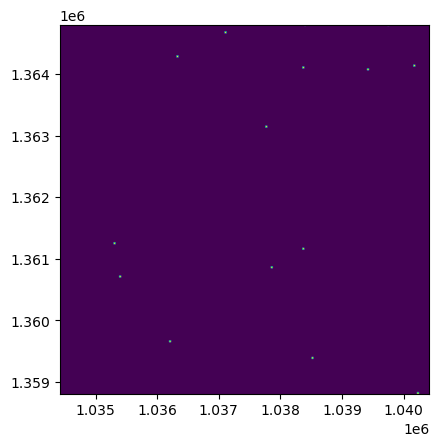

<Axes: >

In [6]:
raster = rio.open('new_dnn.tif')
show(raster)